In [2]:
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import nn
import torch.nn
from torch.functional import F

from tqdm import tqdm
import torch.optim as optim


import matplotlib.pyplot as plt
import os

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from ghostnet import *
from model import *
from model.model import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.chdir('d:\Python Projects\EVA')
cwd = os.getcwd()
# print(cwd)

In [4]:
model_dir = os.path.join(cwd, 'Assignment-6/saved_models')
# os.chdir(model_dir)

In [6]:
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-14.0, 14.0), fill=(1,)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data',train=False, download=True, transform=test_transforms)

In [10]:
type(train)

torchvision.datasets.mnist.MNIST

In [12]:
#
SEED = 1

device = 'cuda' if torch.cuda else 'cpu'
print(device)

# for Reproducable results
torch.manual_seed(SEED)

#Setting seed if CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# # Dataloader Arguments
# dataloader_args = dict(shuffle=True, num_workers=4, batch_size=128, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)

# train_dataloader = DataLoader(train,**dataloader_args)

# test_dataloader = DataLoader(test, **dataloader_args)

cuda


# The Model

In [14]:

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,456
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]           1,450
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

# GhostModel

In [16]:
from ghostnet import *
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ghost = GhostNet().to(device)
# summary(model_ghost, input_size=(1, 28, 28))

In [62]:
model_dir = os.path.join(cwd, 'Assignment-6/saved_models')

def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, l1_loss=False):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)

        # IF L1 Loss
        if l1_loss:
            lambda_l1 = 0.0001
            l1 = 0
            for p in model.parameters():
                l1 = l1 + p.abs().sum()
                loss = loss + lambda_l1*l1
        
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)



def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified):
    # model = torch.load(model_dir)

    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            misclassified.append([index, pred, target])
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))

In [20]:
# Assignment 6

def get_optim(mode):

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.06)

    if mode is 'l2_bn':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0.00001, nesterov=False)
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses)
        scheduler.step()
    
    elif mode is 'l1_bn':
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, l1_loss=True)
        scheduler.step()

    elif mode is 'l1_l2_bn':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0.00001, nesterov=False)
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, l1_loss=True)
        scheduler.step()

    elif mode is 'gbn':
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses)
        scheduler.step()

    elif mode is 'l1_l2_gbn':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0.00001, nesterov=False)
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, l1_loss=True)
        scheduler.step()

0%|          | 0/235 [00:00<?, ?it/s]Mode is gbn
EPOCH -  0
Loss=0.12830589711666107 Batch_id=234 Accuracy=83.27: 100%|██████████| 235/235 [00:27<00:00,  8.51it/s]

Test set: Average loss: 0.1044, Accuracy: 9774/10000 (97.74%)



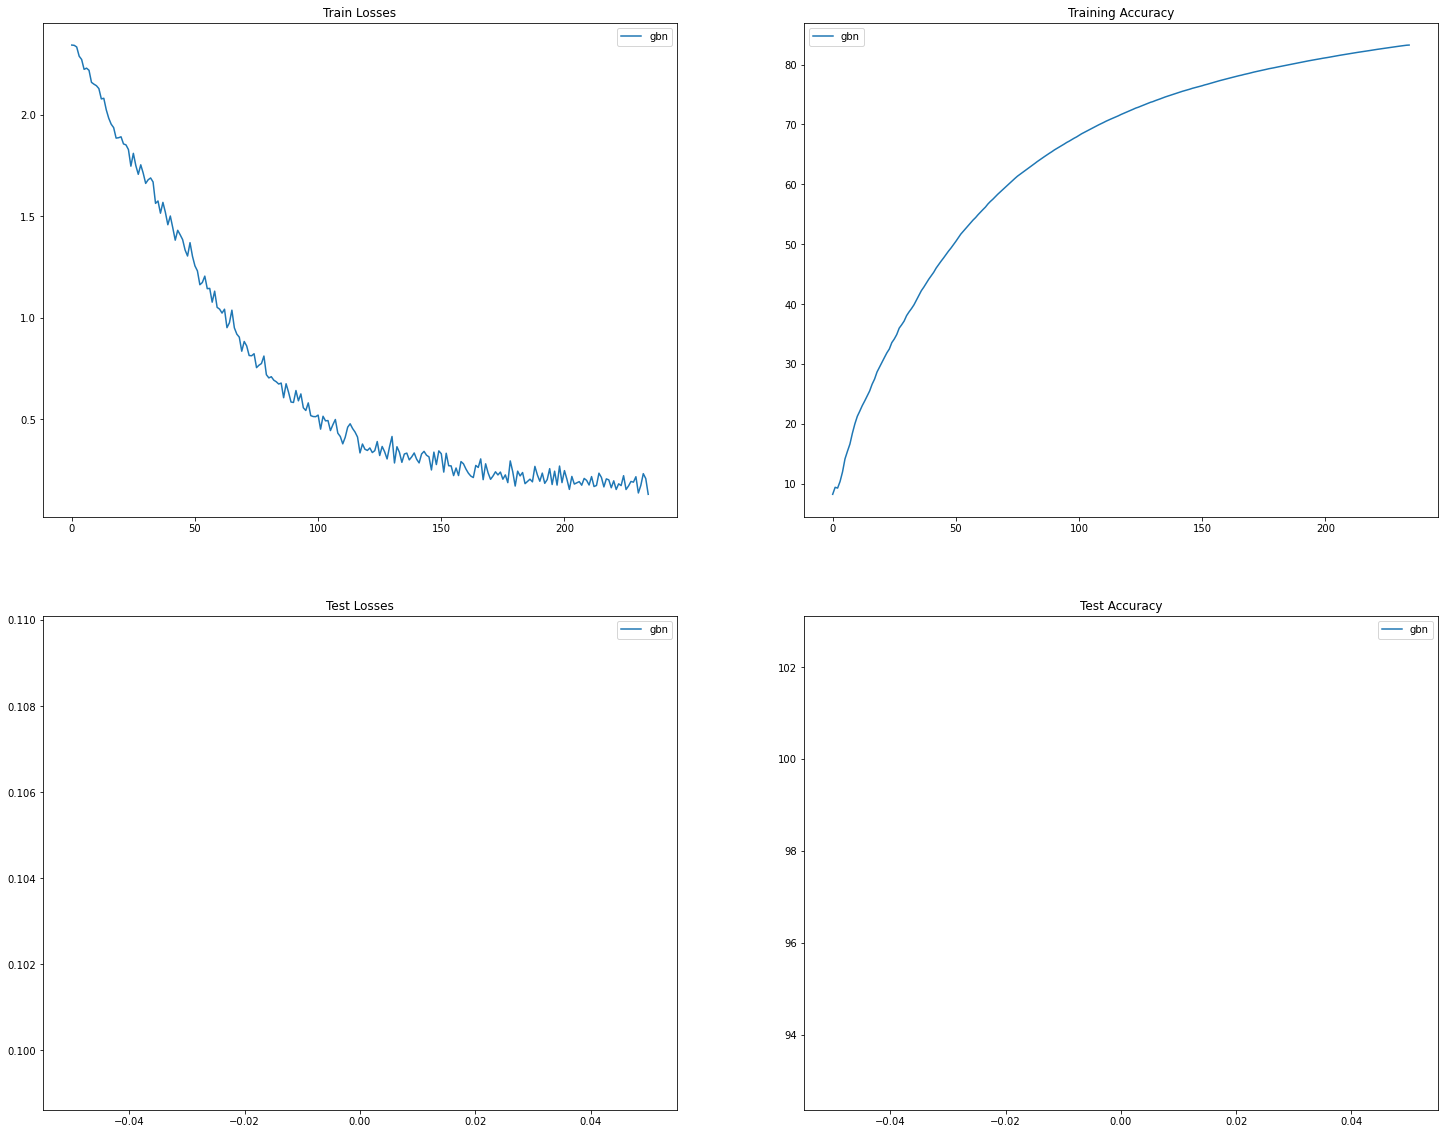

In [47]:
import gc
EPOCHS = 1

# list_modes = ['gbn', 'l1_l2_gbn', 'l1_bn', 'l2_bn', 'l1_l2_bn']
list_modes = ['gbn']
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')


for mode in list_modes:
    gc.collect()
    print(f'Mode is {mode}')

    if mode in ['gbn', 'l1_l2_gbn']:
        model = GhostNet().to(device)
        # print(model)
        dataloader_args = dict(shuffle=True, num_workers=4, pin_memory=True, batch_size=256) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)
    
    else:
        model = Net().to(device)
        dataloader_args = dict(shuffle=True, num_workers=4, pin_memory=True, batch_size=128) if torch.cuda.is_available() else dict(shuffle=True, batch_size=256)
    test_acc = []
    test_losses = []
    train_acc = []
    train_losses = []
    misclassified = []

    train_dataloader = DataLoader(train,**dataloader_args)
    test_dataloader = DataLoader(test, **dataloader_args)
    for epoch in range(EPOCHS):
        print('EPOCH - ', epoch)
        get_optim(mode)
        # torch.save(model.state_dict(), model_dir)
        model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified)
        # if mode is 'gbn':
            # plot_misclassified()


    axs[0,0].plot(train_losses)
    axs[0,1].plot(train_acc)
    axs[1,0].plot(test_losses)
    axs[1,1].plot(test_acc)

axs[0,0].legend(list_modes)
axs[0,1].legend(list_modes)
axs[1,0].legend(list_modes)
axs[1,1].legend(list_modes)
fig.savefig('metrics.jpg')


0
tensor([2, 4, 2, 1, 0, 6, 8, 3, 7, 2, 4, 1, 6, 9, 6, 7, 1, 8, 1, 1, 3, 3, 4, 5,
        8, 3, 6, 2, 0, 5, 8, 2, 7, 6, 5, 1, 5, 1, 8, 5, 6, 5, 7, 8, 4, 8, 3, 8,
        9, 6, 4, 8, 1, 6, 3, 9, 5, 8, 9, 0, 5, 9, 6, 9, 1, 1, 4, 4, 0, 4, 7, 9,
        7, 2, 0, 3, 6, 1, 9, 1, 1, 2, 8, 4, 8, 8, 1, 5, 0, 9, 3, 9, 5, 6, 8, 6,
        7, 1, 1, 3, 8, 3, 4, 8, 8, 4, 1, 9, 5, 5, 0, 8, 3, 9, 9, 2, 7, 2, 7, 0,
        4, 9, 4, 2, 1, 5, 8, 9, 3, 5, 0, 6, 9, 0, 2, 2, 2, 8, 3, 9, 5, 2, 0, 7,
        0, 3, 2, 1, 5, 0, 5, 7, 0, 4, 6, 5, 9, 5, 7, 1, 5, 7, 7, 8, 5, 9, 0, 1,
        9, 0, 0, 1, 1, 6, 7, 2, 2, 1, 9, 7, 7, 1, 0, 5, 9, 1, 0, 5, 5, 5, 9, 1,
        6, 7, 1, 0, 4, 9, 6, 3, 3, 1, 7, 0, 4, 2, 6, 5, 2, 0, 1, 5, 1, 7, 7, 8,
        5, 8, 5, 0, 0, 9, 2, 3, 6, 1, 9, 5, 9, 0, 7, 3, 1, 9, 1, 8, 2, 6, 7, 7,
        6, 3, 5, 1, 9, 2, 2, 5, 0, 9, 9, 5, 5, 3, 5, 4], device='cuda:0')
torch.Size([256, 10])
<class 'list'>


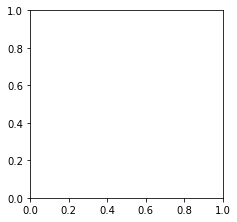

In [67]:
plt.figure(figsize=(20,20))
for plotIndex, badIndex in enumerate(misclassified[0:25]):
    plt.subplot(5, 5, plotIndex + 1)
    # print(len(misclassified))
    print(badIndex[0])
    print(badIndex[2])


    # print(misclassified)
    print(badIndex[1].shape)
    print(type(badIndex))
    # plt.imshow(np.reshape(badIndex[1].cpu(), (28,28)), cmap=plt.cm.gray)
    break
    # plt.title("Predicted: {}, Actual: {}’.format(badIndex[1], badIndex[2]), fontsize = 15)

In [70]:
torch.cuda.get_device_name()

'GeForce GTX 1060'